# Using Prophet For Time Series Forecasting
- We will be using a dataset about hourly energy use

In [2]:
# getting library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [4]:
pjme = pd.read_csv('../../data/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head()

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

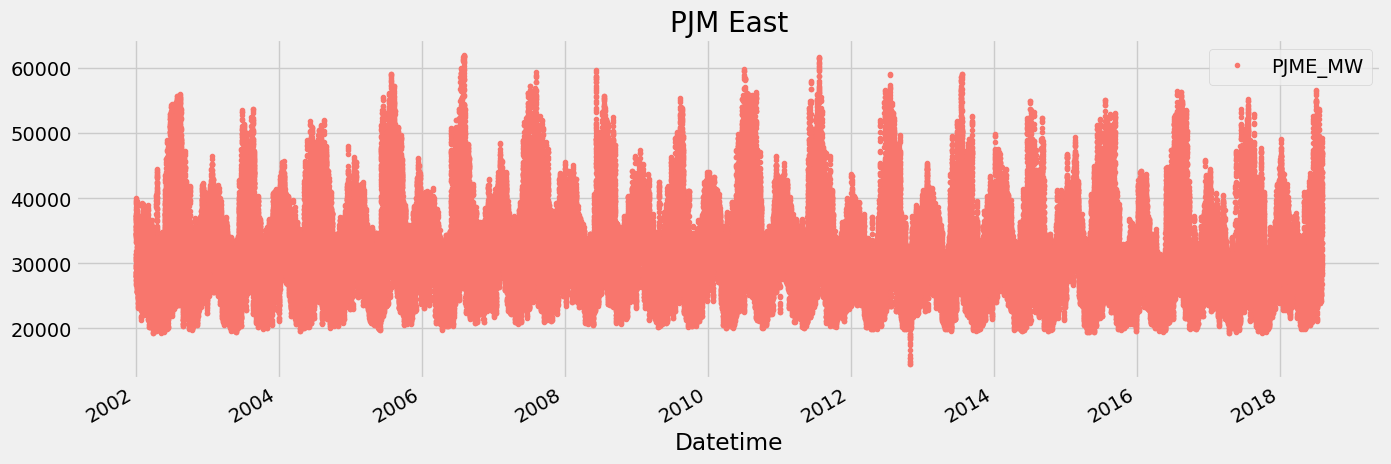

In [5]:
color_pal = [
    '#F8766D', '#D39200', '#93AA00', '#00BA38', '#00C19F', '#00B9E3', '#619CFF', '#DB72FB'
]

pjme.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJM East')
plt.show()

In [11]:
# creating time series features
# no week of year
def create_features(df, label = None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth']]
    
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [12]:
features_and_target.head()

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-12-31 01:00:00     1          1        4     12  2002        365   
2002-12-31 02:00:00     2          1        4     12  2002        365   
2002-12-31 03:00:00     3          1        4     12  2002        365   
2002-12-31 04:00:00     4          1        4     12  2002        365   
2002-12-31 05:00:00     5          1        4     12  2002        365   

                     dayofmonth  PJME_MW  
Datetime                                  
2002-12-31 01:00:00          31  26498.0  
2002-12-31 02:00:00          31  25147.0  
2002-12-31 03:00:00          31  24574.0  
2002-12-31 04:00:00          31  24393.0  
2002-12-31 05:00:00          31  24860.0

# EDA

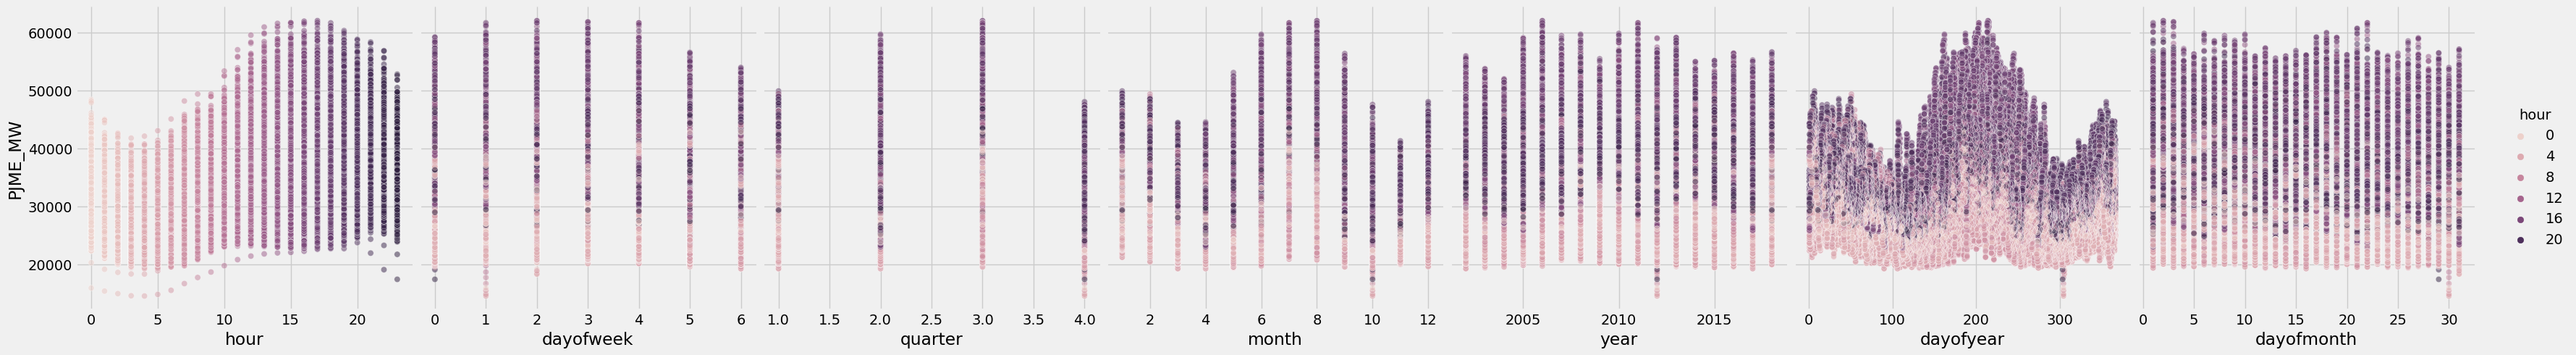

In [13]:
sns.pairplot(features_and_target.dropna(), hue='hour', x_vars=['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth'], y_vars='PJME_MW', height=5, plot_kws={'alpha': 0.5})
plt.show()

# Train Test Split

In [15]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

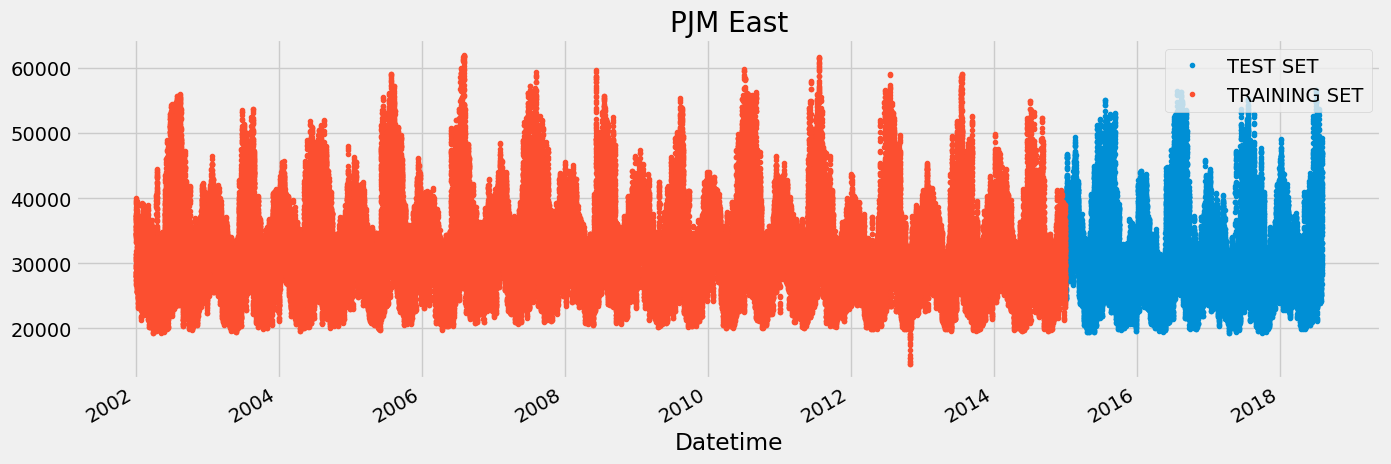

In [16]:
# plot the train and test together with different color
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}).join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
                                                        how='outer').plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()

In [17]:
# format the data
pjme_train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'}).head()

ds        y
0 2002-12-31 01:00:00  26498.0
1 2002-12-31 02:00:00  25147.0
2 2002-12-31 03:00:00  24574.0
3 2002-12-31 04:00:00  24393.0
4 2002-12-31 05:00:00  24860.0

In [18]:
# setup the model
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'}))

16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:57 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# predict on training set
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime': 'ds'}))

In [20]:
pjme_test_fcst.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-01 01:00:00  31212.530968  23970.067158  32978.390611  31212.530968   
1 2015-01-01 02:00:00  31212.493464  22570.020457  31230.661607  31212.493464   
2 2015-01-01 03:00:00  31212.455959  21599.706416  30456.152273  31212.455959   
3 2015-01-01 04:00:00  31212.418455  21458.774420  30326.356478  31212.418455   
4 2015-01-01 05:00:00  31212.380951  21965.868370  31005.114730  31212.380951   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  31212.530968    -2834.654169          -2834.654169          -2834.654169   
1  31212.493464    -4339.004112          -4339.004112          -4339.004112   
2  31212.455959    -5210.680503          -5210.680503          -5210.680503   
3  31212.418455    -5352.210995          -5352.210995          -5352.210995   
4  31212.380951    -4677.851747          -4677.851747          -4677.851747   

         daily  ...       weekly  weekly_lower  weekly_upper      yearly  \
0 -4430.318681  ...  1281.410100   1281.410100   1281.410100  314.254412   
1 -5927.227470  ...  1272.649977   1272.649977   1272.649977  315.573381   
2 -6790.298656  ...  1262.684325   1262.684325   1262.684325  316.933828   
3 -6922.183507  ...  1251.636733   1251.636733   1251.636733  318.335779   
4 -6237.274004  ...  1239.642999   1239.642999   1239.642999  319.779258   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    314.254412    314.254412                   0.0   
1    315.573381    315.573381                   0.0   
2    316.933828    316.933828                   0.0   
3    318.335779    318.335779                   0.0   
4    319.779258    319.779258                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  28377.876799  
1                         0.0                         0.0  26873.489352  
2                         0.0                         0.0  26001.775456  
3                         0.0                         0.0  25860.207460  
4                         0.0                         0.0  26534.529203  

[5 rows x 22 columns]

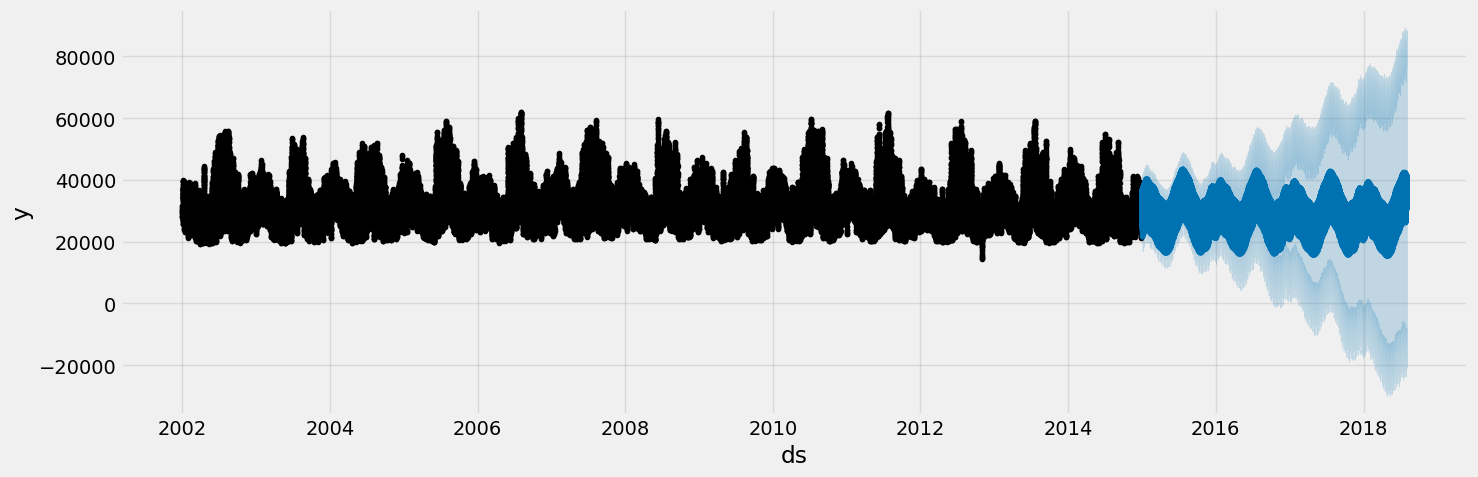

In [21]:
# plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst, ax=ax)
plt.show()

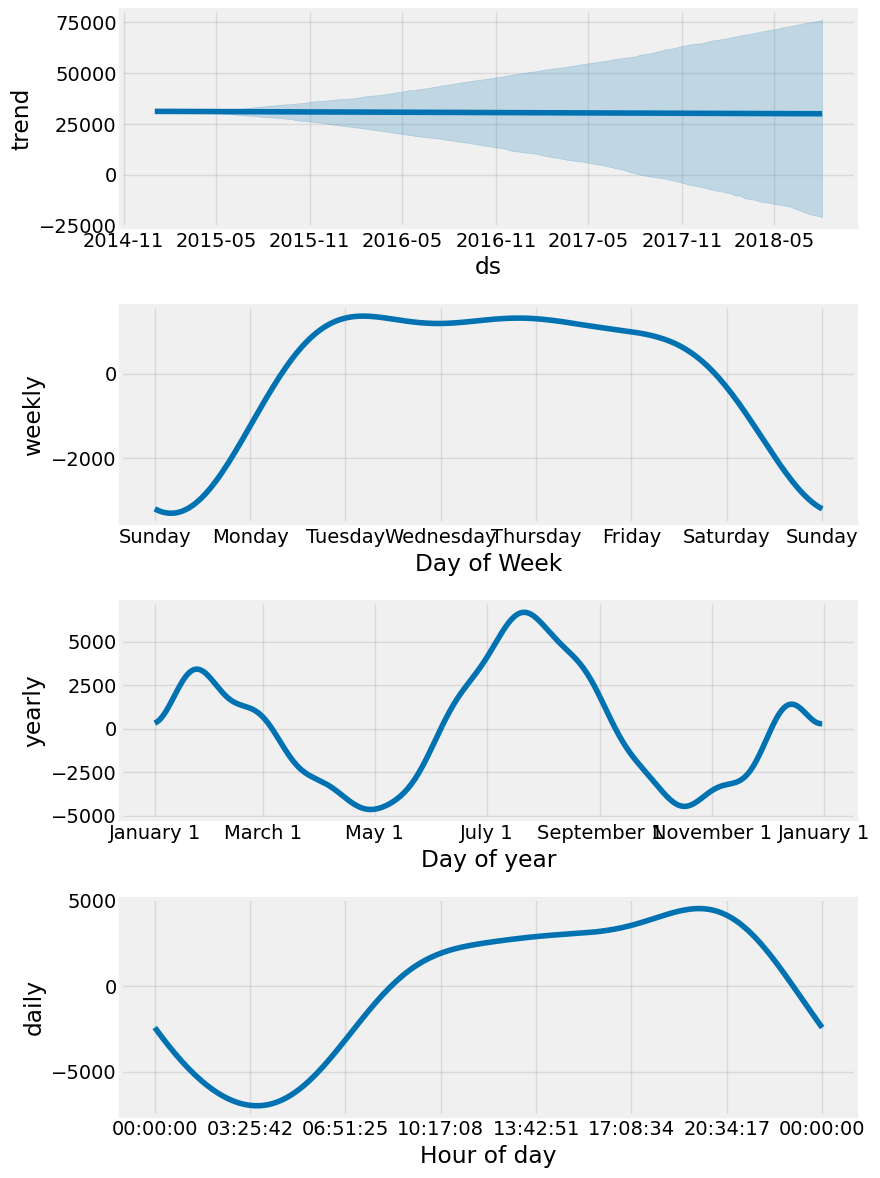

In [22]:
# plot the ts components
fig = model.plot_components(pjme_test_fcst)

# Compare With Actual Values

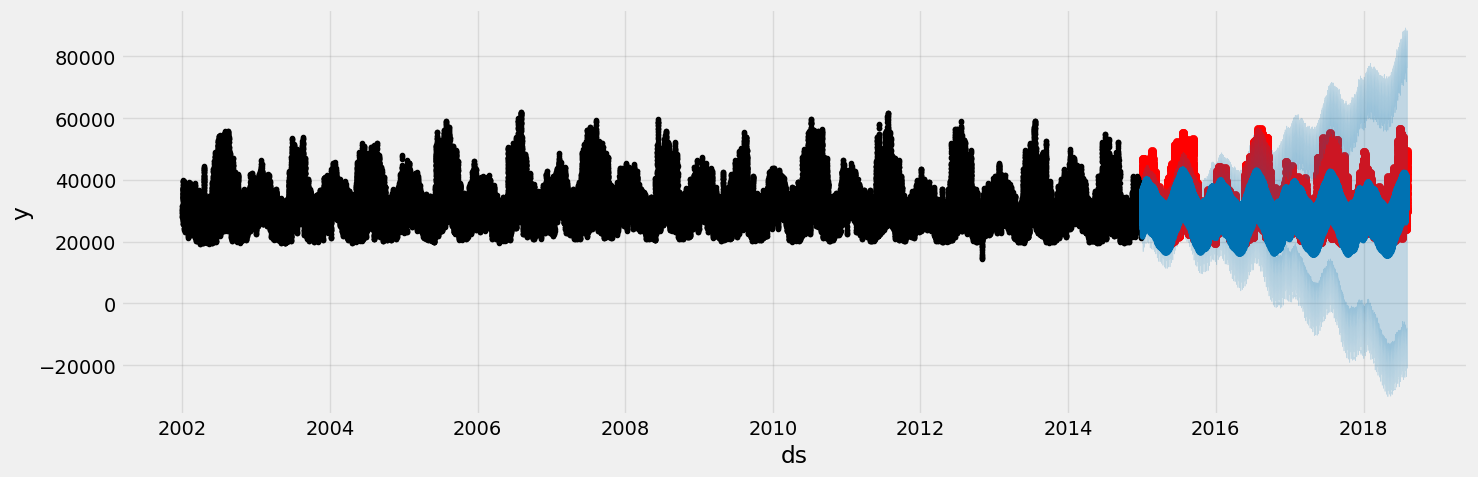

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

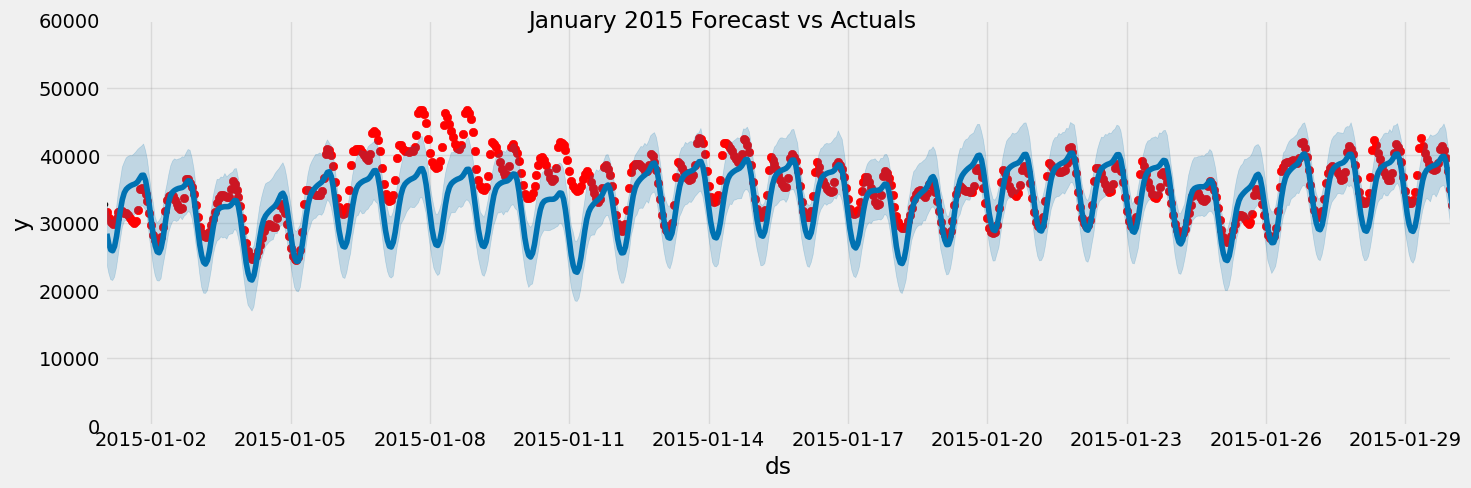

In [47]:
# a closer look (first 30 days)
import datetime

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.date(2015,1,1), upper=datetime.date(2015, 1, 30))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

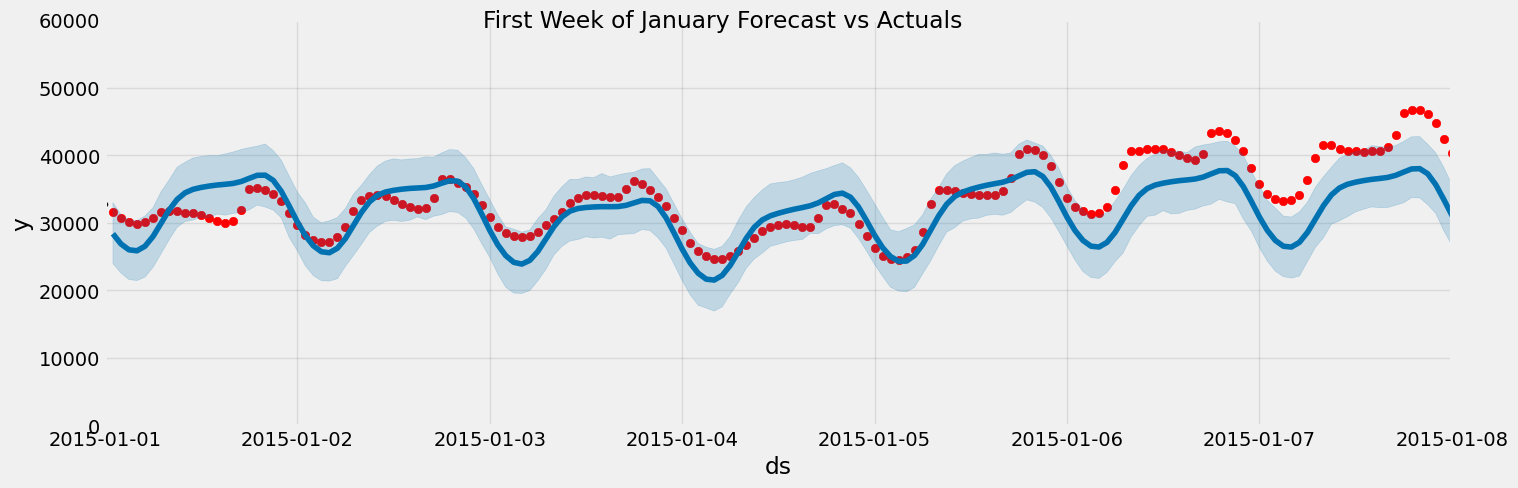

In [48]:
# a close look, first week

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.date(2015,1,1), upper=datetime.date(2015, 1, 8))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Evaluation

In [49]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                     y_pred=pjme_test_fcst['yhat'])

43773963.45554562

In [50]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                        y_pred=pjme_test_fcst['yhat'])

5182.618461840381

In [52]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                    y_pred=pjme_test_fcst['yhat'])

16.510971456525887

# Holiday Effects

In [53]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [55]:
# holiday dateframe
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

ds           holiday
0 2003-01-01 00:00:00  USFederalHoliday
1 2002-12-25 01:00:00  USFederalHoliday
2 2002-12-25 02:00:00  USFederalHoliday
3 2002-12-25 03:00:00  USFederalHoliday
4 2002-12-25 04:00:00  USFederalHoliday

In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [56]:
# setup another model
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'}))

16:32:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:40 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# predict on training set
pjme_test_fcst_with_holidays = model_with_holidays.predict(df=pjme_test.reset_index().rename(columns={'Datetime': 'ds'}))

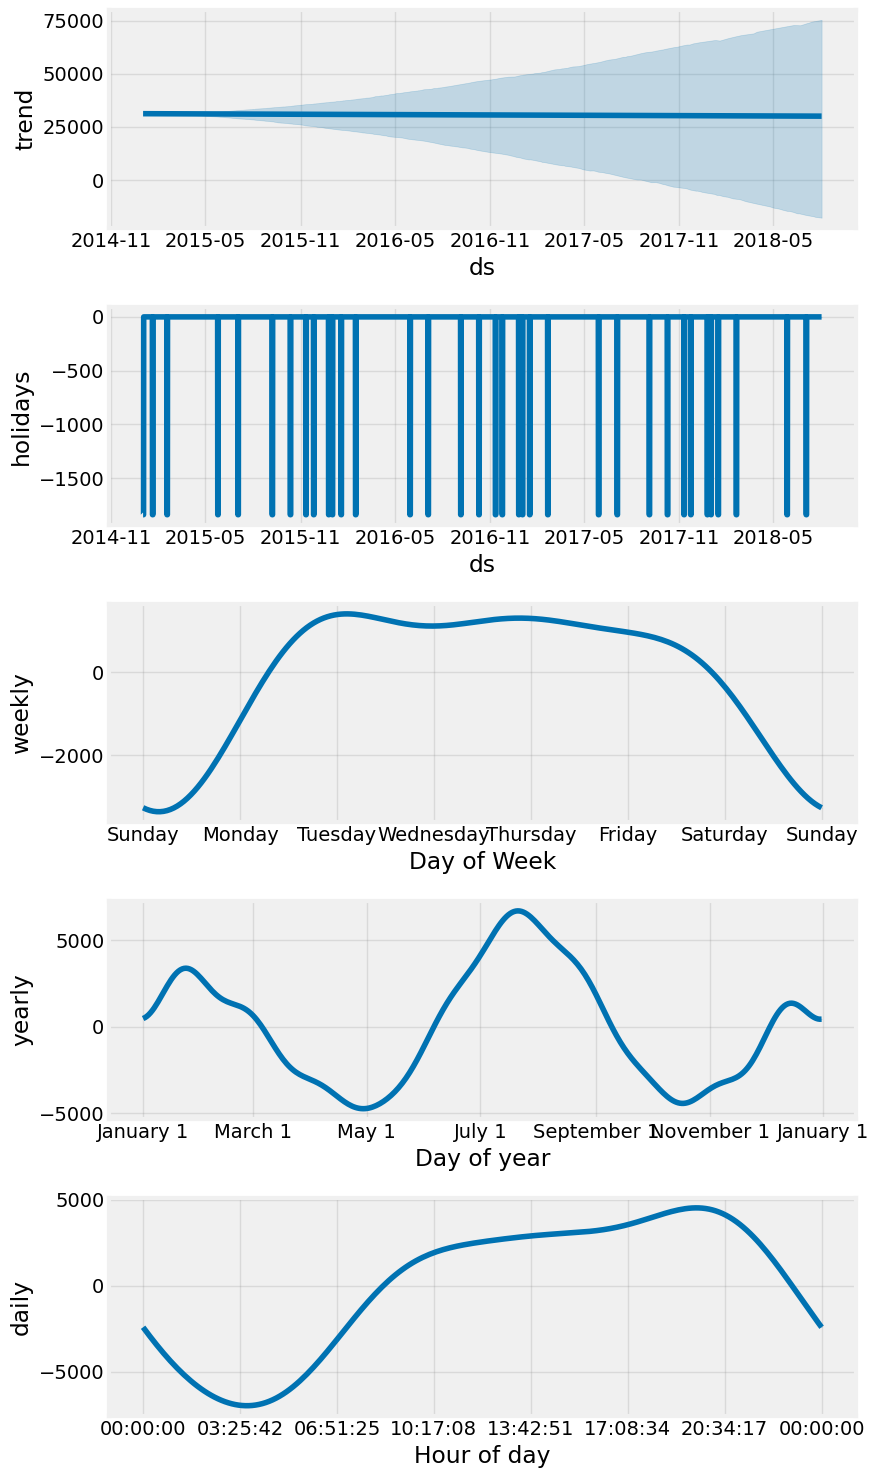

In [58]:
# plot the components
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_holidays)

In [59]:
# evaluation
mean_squared_error(y_true=pjme_test['PJME_MW'],
                        y_pred=pjme_test_fcst_with_holidays['yhat'])

43885560.6231813

In [60]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                        y_pred=pjme_test_fcst_with_holidays['yhat'])

5190.387193267287

In [61]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                    y_pred=pjme_test_fcst_with_holidays['yhat'])

16.541635216738726

# Compare Models Just for Holiday Dates

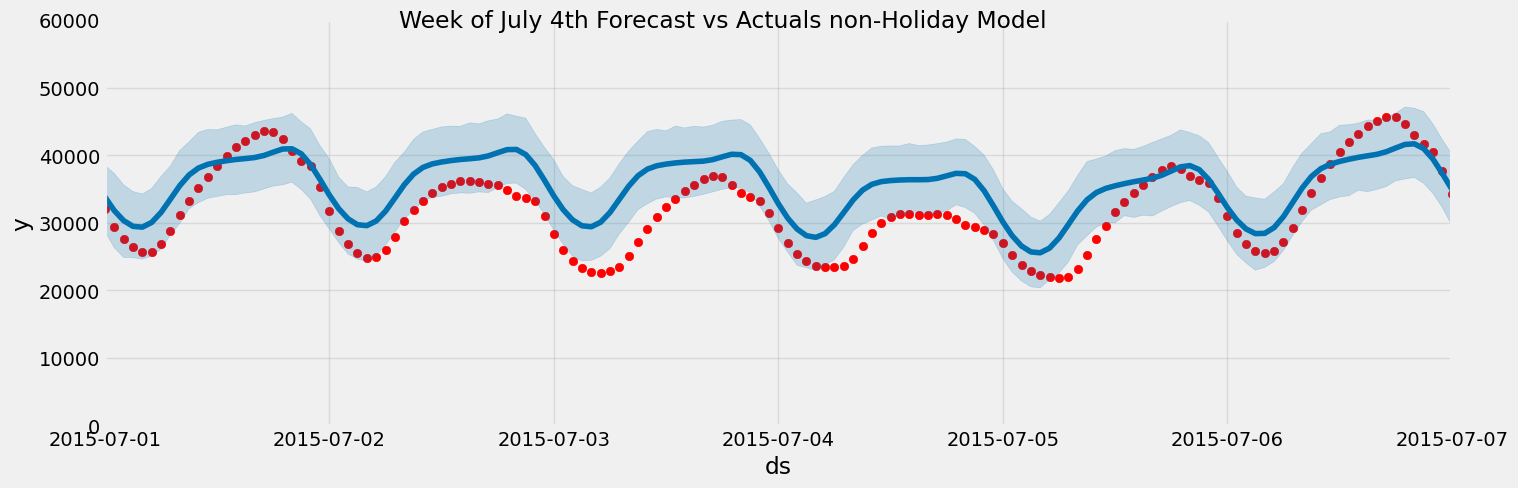

In [62]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.date(2015,7,1), upper=datetime.date(2015, 7, 7))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

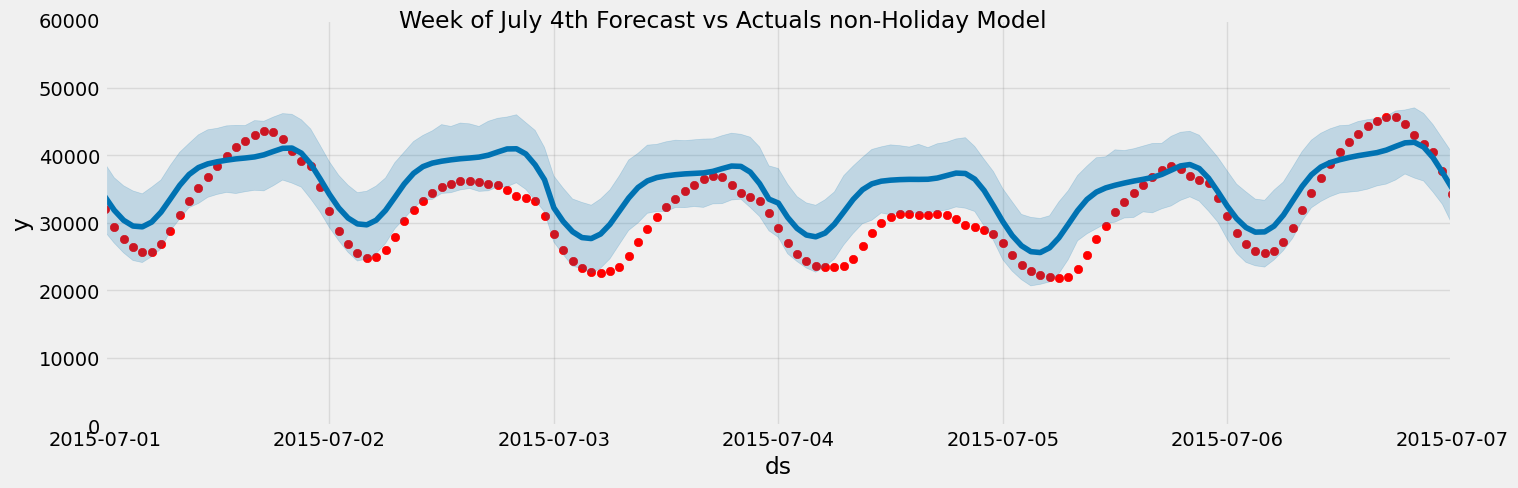

In [63]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_holidays, ax=ax)
ax.set_xbound(lower=datetime.date(2015,7,1), upper=datetime.date(2015, 7, 7))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

In [65]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_holidays.query('ds >= 20160407 and ds < 20160408')

In [66]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                        y_pred=jul4_pred['yhat'])

2159.9861787943278

In [67]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                        y_pred=jul4_pred_holiday_model['yhat'])

2157.898298439548

# Error of All Holidays

In [68]:
holiday_list = holiday_df['ds'].tolist()

In [70]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_holidays.query('ds in @holiday_list')

In [71]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5230.536064655262

In [72]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                     y_pred=hols_pred_holiday_model['yhat'])

5120.473959857305

# Identify Error by Holiday

In [74]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_holidays.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3102.0 
 MAE (Holiday Model): 2672.7 
 Diff 429.4
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2424.8 
 MAE (Holiday Model): 2088.3 
 Diff 336.5
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11081.0 
 MAE (Holiday Model): 12741.4 
 Diff -1660.4
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1557.9 
 MAE (Holiday Model): 1622.1 
 Diff -64.2
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6022.1 
 MAE (Holiday Model): 4279.5 
 Diff 1742.7
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.8 
 MAE (Holiday Model): 4338.2 
 Diff -486.4
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1582.3 
 MAE (Holiday Model): 1893.8 
 Diff -311.5
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2048.1 
 MAE (Holiday Model): 1586.3 
 Diff 461.7
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4672.4 
 MAE (Holiday Model): 3780.9 
 Diff 891.5
Holiday: December 25, 2015:    


# Plot the Error

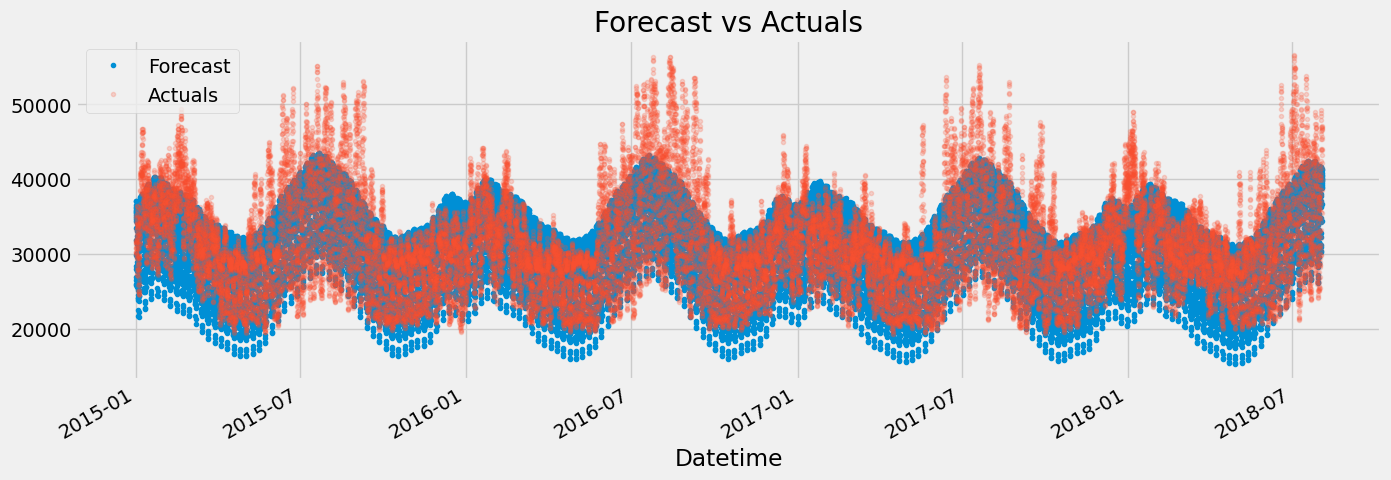

In [78]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5), lw = 0, style = '.')
pjme_test['PJME_MW'].plot(ax = ax, style = '.', lw = 0.5, alpha = 0.2)
plt.legend(['Forecast', 'Actuals'])
plt.title('Forecast vs Actuals')
plt.show()

# Data Cleaning

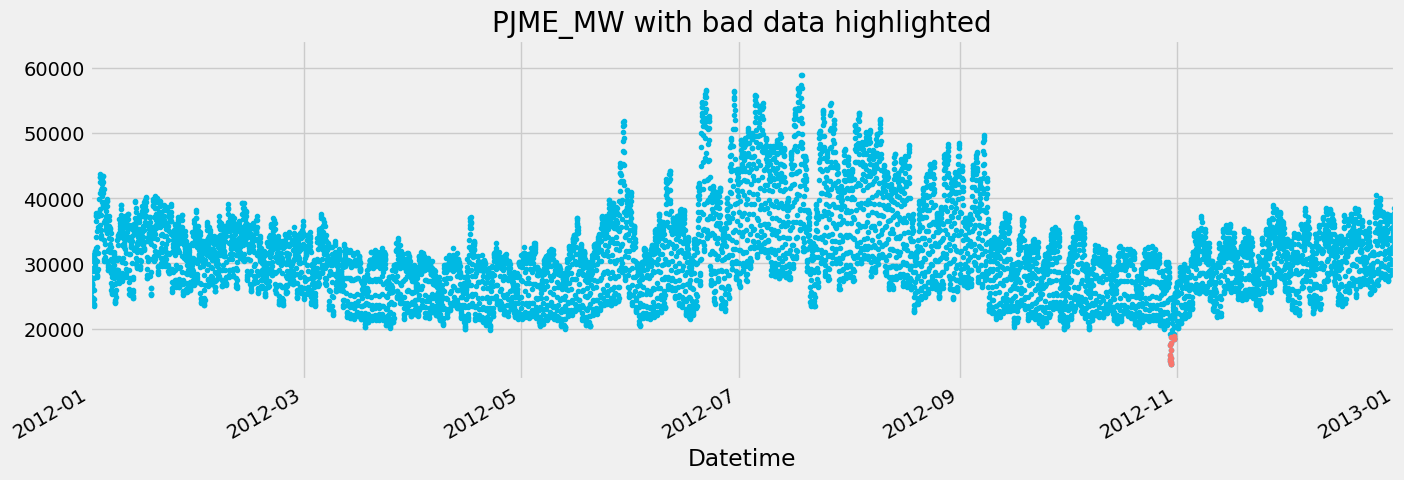

In [79]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

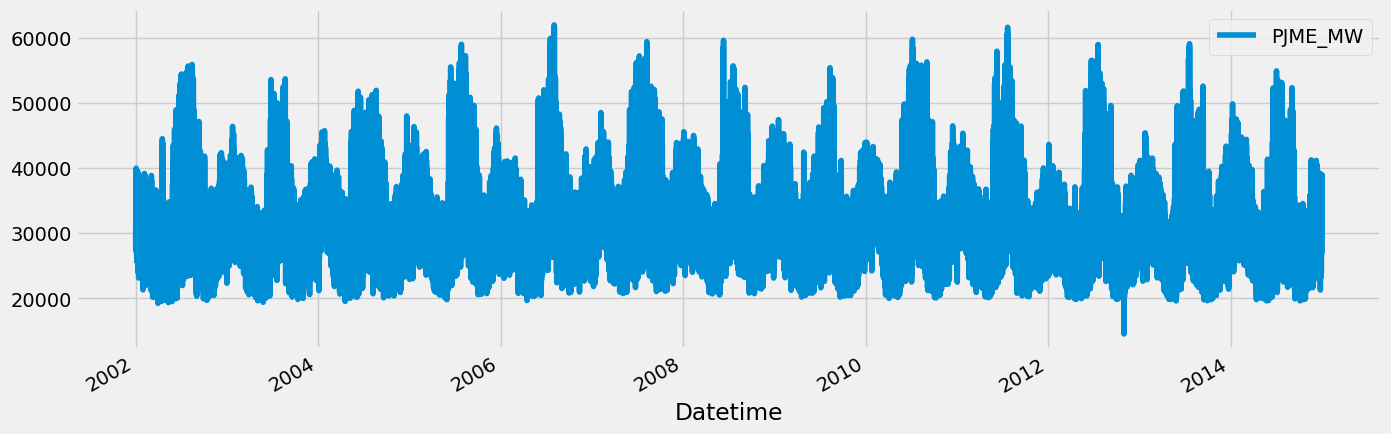

In [80]:
pjme_train.plot(figsize=(15, 5))
plt.show()

What caused this dip in energy demand? Hurricane Sandy! Check out this wikipedia article: https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. The storm, which came ashore near Atlantic City, New Jersey as a Category 1 hurricane, ultimately left scores of homes and businesses without power in New Jersey (2.7 million), New York (2.2 million), Pennsylvania (1.2 million), Connecticut (620,000), Massachusetts (400,000), Maryland (290,000), West Virginia (268,000), Ohio (250,000), and New Hampshire (210,000). Power outages were also reported in a number of other states, including Virginia, Maine, Rhode Island, Vermont, and the District of Columbia.

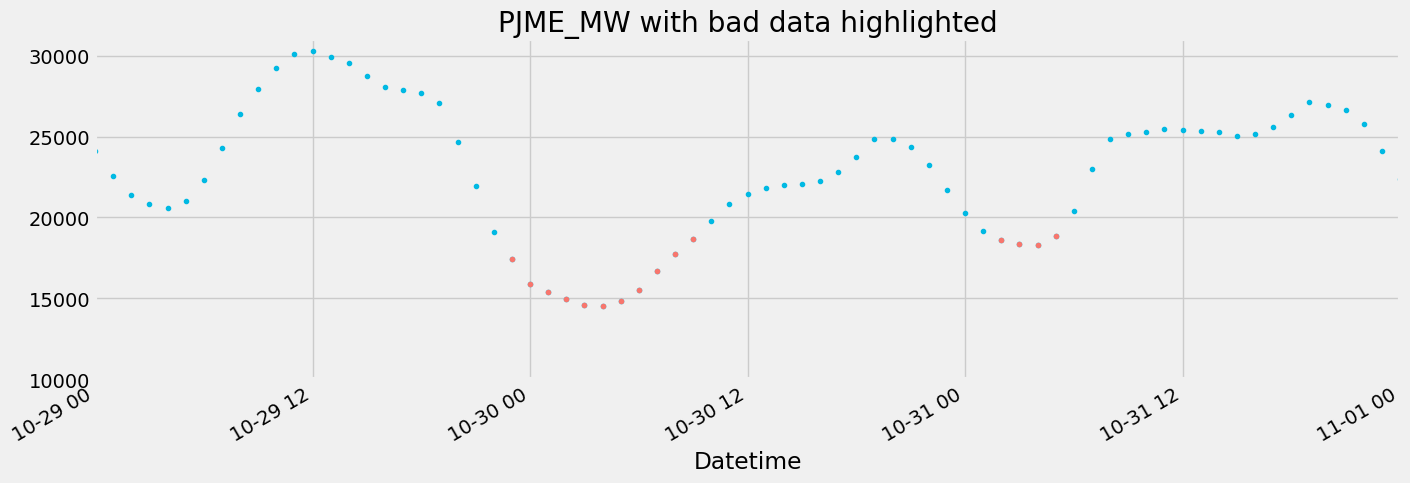

In [81]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [82]:
# clean the data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

16:43:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:22 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
# check the error of the cleaned data
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43788561.1524 - MAE 5182.3497 - MAPE 16.5045


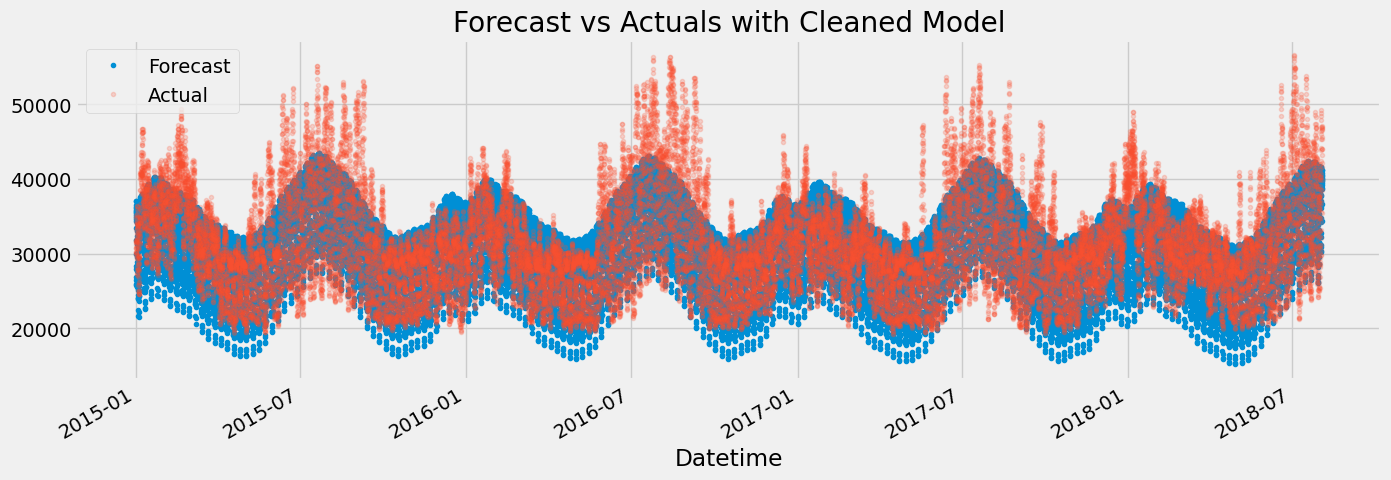

In [84]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()